## CNN autoencoder
### convLSTM autoencoder?

## Prepare data

In [1]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.layers import Conv3D
from keras.layers import MaxPool3D
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array

In [2]:
from data_processing import process
filename = 'gear_dataset.csv'
rows = 10000  # no attack data in the first 1000 rows
data_with_attack, AIDs = process(filename,rows,no_attack_packets=False) # change name of attackIDs..
data , IDs = process(filename,rows,no_attack_packets=True)
n_rows = data.shape[0] 
n_features = data.shape[1]
print(data.shape)



number of attack packets in data set = 2124
dropped 2124 attack packets
(7797, 64)


In [3]:
# do cube with stream*64*ID

def convert_from_hex(hex,output_type): # converts the data in hex from hexadecimal to decimal or binary form
     out = np.zeros((hex.size))
     if output_type == 'dec':
        for x in range(hex.size):
            h_value = hex[x]
            out[x] = int(h_value,16)
     else:
        for x in range(hex.size):
            h_value = hex[x]
            binary[x] = bin(int(h_value, 16))[2:]

     return out


#data = convert_from_hex(Data,'dec')
IDs = IDs.reset_index(drop=True)

id = convert_from_hex(IDs,'dec') 

ID_matrix =  array([[id],]*data.shape[1]).transpose()
ID_matrix = np.squeeze(ID_matrix)
dataCube = np.dstack([data,ID_matrix])


In [4]:
AttackIDs = AIDs.reset_index(drop=True)

Attackid = convert_from_hex(AttackIDs,'dec') 

ID_matrixA =  array([[Attackid],]*data_with_attack.shape[1]).transpose()
ID_matrixA = np.squeeze(ID_matrixA)
dataCubeA = np.dstack([data_with_attack,ID_matrixA])

In [5]:
n_timesteps = 40
n_samples = int(np.floor(dataCube.shape[0]/n_timesteps))
print(n_samples)

last_timestep = n_samples*n_timesteps
x = dataCube[0:last_timestep,:,:]
print(x.shape)
x = x.reshape(n_samples,n_timesteps,64,2,1)
print(x.shape)

train_size = int(np.floor(0.7*n_samples))
x_train = x[0:train_size,:,:,:,:]
x_test = x[train_size:,:,:,:,:]

print(x_test.shape, x_train.shape)

194
(7760, 64, 2)
(194, 40, 64, 2, 1)
(59, 40, 64, 2, 1) (135, 40, 64, 2, 1)


In [6]:
n_samples = int(np.floor(dataCubeA.shape[0]/n_timesteps))
print(n_samples)

last_timestep = n_samples*n_timesteps
xA = dataCubeA[0:last_timestep,:,:]
print(xA.shape)
xA = xA.reshape(n_samples,n_timesteps,64,2,1)
print(xA.shape)



248
(9920, 64, 2)
(248, 40, 64, 2, 1)


## Build network

In [7]:
# channels?? 2d or 3d? think 3d because there are correlations between the two cannels
# relu much better than sigmoid
n_features = 64
depth = 2

input = Input(shape=(n_timesteps,n_features,depth, 1))

l1 = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(input) 
l2 = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(l1)
#l3 = MaxPool3D((2,2,2),padding='valid')(l2)
l4 = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(l2)
l5 = Conv3D(filters = 1, kernel_size = (2, 2, 1), activation='relu', padding='same')(l4)


CNN = Model(inputs=input, outputs=l5,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 64, 2, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 40, 64, 2, 60)     300       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 40, 64, 2, 1)      241       
Total params: 29,461
Trainable params: 29,461
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
5/5 - 7s - loss: 221281.4219 - val_loss: 104001.6406
Epoch 2/300
5/5 - 6s - loss: 96875.3203 - val_loss: 102097.7422
Epoch 3/300
5/5 - 6s - loss: 88337.9219 - val_loss: 66053.3906
Epoch 4/300
5/5 - 6s - loss: 66530.7422 - val_loss: 54604.3203
Epoch 5/300
5/5 - 6s - loss: 50198.9609 - val_loss: 37277.7539
Epoch 6/300
5/5 - 6s - loss: 36688.0078 - val_loss: 21778.4023
Epoch 7/300
5/5 - 6s - loss: 22479.4766 - val_loss: 11521.8789
Epoch 8/300
5/5 - 5s - loss: 12035.6875 - val_loss: 5909.7480
Epoch 9/300
5/5 - 5s - loss: 6537.1353 - val_loss: 5123.1421
Epoch 10/300
5/5 - 6s - loss: 5642.0210 - val_loss: 4274.8457
Epoch 11/300
5/5 - 6s - loss: 3997.6094 - val_loss: 2457.8113
Epoch 12/300
5/5 - 6s - loss: 2403.4248 - val_loss: 1838.9661
Epoch 13/300
5/5 - 6s - loss: 1950.3525 - val_loss: 1578.3219
Epoch 14/300
5/5 - 7s - loss: 1645.6599 - val_loss: 1385.9631
Epoch 15/300
5/5 - 8s - loss: 1439.4567 - val_loss: 1249.6506
Epoch 16/300
5/5 - 7s - loss: 1299.2092 - val_loss: 1107.3350

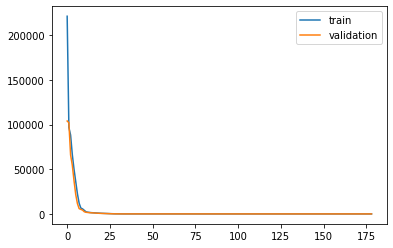

training time = 1344.434950351715 seconds


In [8]:

import time

model = CNN
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s = time.time()

history = model.fit(x_train,x_train, validation_data=(x_test, x_test), epochs=300, verbose=2, shuffle=False, callbacks = [es])

e = time.time()

# plot history
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')

input = Input(shape=(n_timesteps,n_features,n_channels, 1))

    *l1 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(input) * these are changed, kernel size and filters
    *l2 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l1)
#l3 = MaxPool3D((2,2,2),padding='valid')(l2)
    *l4 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l2)
    l5 = Conv3D(filters = 1, kernel_size = (2, 2, 2), activation='relu', padding='same')(l4) only change kernel size here
all using nrows = 1000, patience = 10, epochs = 300 

kernel in third dim must be smaller than input to be able to establish correlations in this dim.

loss: 120.9649 - val_loss: 235.5185 for kernel = 3,3,1, 16 filters    
loss: 76.3744 - val_loss: 161.5475 for kernel = 3,3,3, 16 filters  
loss: 6.2998 - val_loss: 7.3455 for kernel = 2, 2, 2, 60 filters  
loss: 24 - val_loss: 21.1457 for kernel = 2, 2, 2, 80 filters  
loss: 3.4384 - val_loss: 4.4540 for kernel = 2, 2, 1, 60 filters
loss: 8.4616 - val_loss: 604.7426 for kernel = 10, 2, 1, 60 filters (training time = 2193.382426261902 seconds) 

using nrows = 10000:
early stopping: Epoch 218/300: loss: 0.7777 - val_loss: 0.7862 (best around epoch 208:loss: 0.4987 - val_loss: 0.4804) for kernel = 2, 2, 1, 60 filters 40 timesteps!

In [9]:
# test with attack included

from matplotlib import pyplot as plt  

yHat_normal = CNN.predict(x_test)
normal_errors = x_test-yHat_normal
print(yHat_normal.shape)
normal_errors = normal_errors.flatten()
normal_errors = np.abs(normal_errors)
normal_errors = np.mean(normal_errors)
print(normal_errors)


yHat_attack = CNN.predict(xA)
attack_errors = xA-yHat_attack
print(yHat_attack.shape)
attack_errors = attack_errors.flatten()
attack_errors = np.abs(attack_errors)
attack_errors = np.mean(attack_errors)
print(attack_errors)


#%% Error distribution
# plt.boxplot([attack_errors, normal_errors]) 
# plt.xticks([1,2], ['Normal','Attack'], rotation='vertical', fontsize=14)
# plt.ylabel('Error Sum Per Packet', fontsize=14)
# plt.title('Gear Dataset, trained on all normal data\nFeedforward AutoEncoder', fontsize=16)

(59, 40, 64, 2, 1)
0.5207472384494178
(248, 40, 64, 2, 1)
0.5224614323943716


(59, 40, 64, 2, 1)
(59, 5120)
(59,)
(248, 40, 64, 2, 1)
(248, 5120)
(248,)


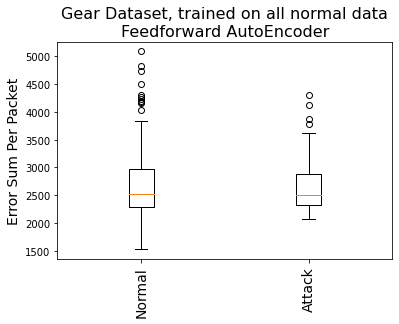

In [39]:
# get average for each sample cube 

yHat_normal = CNN.predict(x_test)
normal_errors = x_test-yHat_normal
print(normal_errors.shape)
normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2]*normal_errors.shape[3])
print(normal_errors.shape)
normal_errors = np.abs(normal_errors)
normal_errors = np.sum(normal_errors,axis=1)
#normal_errors = normal_errors/normal_errors.shape[0]
print(normal_errors.shape)


yHat_attack = CNN.predict(xA)
attack_errors = xA-yHat_attack
print(attack_errors.shape)
attack_errors = attack_errors.reshape(attack_errors.shape[0],attack_errors.shape[1]*attack_errors.shape[2]*attack_errors.shape[3])
print(attack_errors.shape)
attack_errors = np.abs(attack_errors)
attack_errors = np.sum(attack_errors,axis=1)
#attack_errors = attack_errors/attack_errors.shape[0]
print(attack_errors.shape)

plt.figure()
plt.boxplot([attack_errors, normal_errors]) 
plt.xticks([1,2], ['Normal','Attack'], rotation='vertical', fontsize=14)
plt.ylabel('Error Sum Per Packet', fontsize=14)
plt.title('Gear Dataset, trained on all normal data\nFeedforward AutoEncoder', fontsize=16)
A = np.arange(len(normal_errors)) #np.linspace(1,len(normal_errors),len(normal_errors))
B = np.arange(len(attack_errors))#np.linspace(1,len(attack_errors), len(attack_errors))
# plt.figure()
# plt.scatter(range(len(normal_errors)), normal_errors,'r')
# plt.scatter(range(len(attack_errors)), attack_errors,'b')

In [30]:
# CNN AE

print(attack_errors)
plt.scatter(normal_errors,attack_errors)

[1899.29859276 1929.12444958 2355.9058451  2344.77868639 2093.03715957
 1705.15054527 1918.46143315 2228.66821389 2258.08392929 2442.32789422
 2015.89208098 2009.15810612 2300.78356617 1953.70408545 1974.55987827
 2314.48390393 2188.1201031  2335.87620763 1867.38399418 1788.59518338
 2279.10426877 2166.85197004 2352.52258703 2693.24460752 1845.51395533
 2182.05320657 2137.3903795  1960.7448134  1964.2266249  2159.92227941
 2500.65074836 2531.82515594 1960.38964994 2510.16265681 2331.77305347
 2244.11456318 1976.13261025 3269.71733335 2027.85441574 2476.36084147
 2239.34159419 1809.47100183 2198.78443428 1533.14572489 2433.30661877
 1866.23774832 1844.22747838 1576.65148076 2394.90970377 2083.08868643
 1727.02539325 1856.63291476 2437.03310015 2927.91842914 3711.22795668
 2903.59714615 4732.82872121 2246.22868239 3150.18733562 2535.43312079
 3455.00256423 4184.97437295 2606.16412996 2627.97100342 2540.42514313
 3106.19382299 2511.49930906 2936.46234134 2926.19077206 2063.9052476
 4496.0

ValueError: x and y must be the same size

In [32]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])